<a href="https://colab.research.google.com/github/fmhirwa/time_series_forecasting/blob/main/Time_Series_Florent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Section 1. Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model


Section 2: Load and pre-processing

1. Dataset Load

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# Load datasets
train_data = pd.read_csv('./train.csv')
test_data = pd.read_csv('./test.csv')

# Convert 'datetime' column to datetime type
train_data['datetime'] = pd.to_datetime(train_data['datetime'])
test_data['datetime'] = pd.to_datetime(test_data['datetime'])

# Set datetime as the index
train_data.set_index('datetime', inplace=True)
test_data.set_index('datetime', inplace=True)

# Display the structure and first rows
print("Train Data Info:")
print(train_data.info())
print("\nTest Data Info:")
print(test_data.info())
train_data.head()


Train Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30676 entries, 2010-01-01 00:00:00 to 2013-07-02 03:00:00
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   No       30676 non-null  int64  
 1   DEWP     30676 non-null  float64
 2   TEMP     30676 non-null  float64
 3   PRES     30676 non-null  float64
 4   Iws      30676 non-null  float64
 5   Is       30676 non-null  float64
 6   Ir       30676 non-null  float64
 7   cbwd_NW  30676 non-null  float64
 8   cbwd_SE  30676 non-null  float64
 9   cbwd_cv  30676 non-null  float64
 10  pm2.5    28755 non-null  float64
dtypes: float64(10), int64(1)
memory usage: 2.8 MB
None

Test Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13148 entries, 2013-07-02 04:00:00 to 2014-12-31 23:00:00
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   No       13148 non-null  int64  
 1   DEWP     

,No,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
datetime,,,,,,,,,,,
2010-01-01 00:00:00,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,NaN
2010-01-01 01:00:00,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,NaN
2010-01-01 02:00:00,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,NaN
2010-01-01 03:00:00,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,NaN
2010-01-01 04:00:00,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,NaN


2. Data Exploration
Visualize PM2.5 Trends Over Time
Analyze the overall distribution and time-series trends.

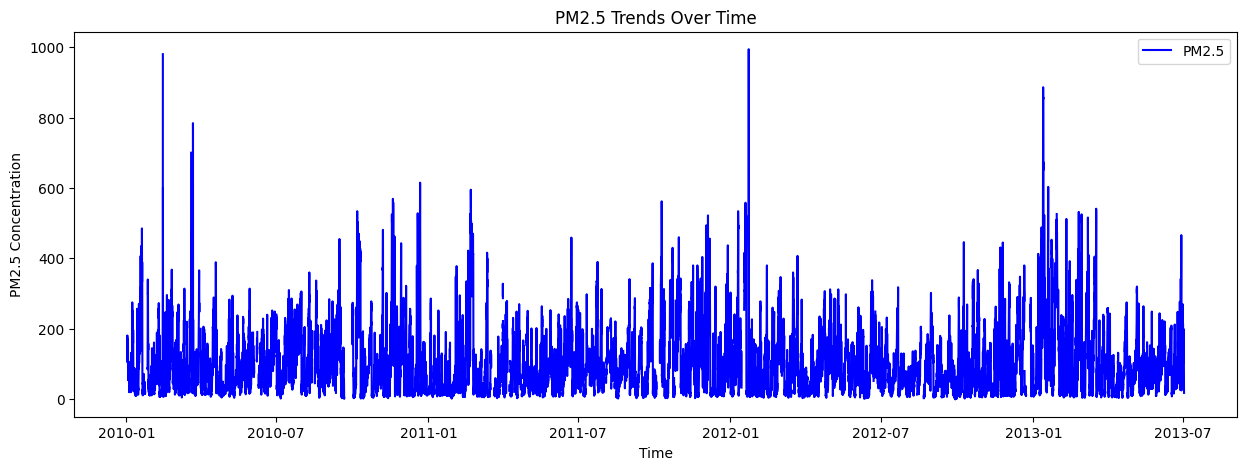

In [3]:
# Plot PM2.5 over time (train data)
plt.figure(figsize=(15, 5))
plt.plot(train_data['pm2.5'], label='PM2.5', color='blue')
plt.title('PM2.5 Trends Over Time')
plt.xlabel('Time')
plt.ylabel('PM2.5 Concentration')
plt.legend()
plt.show()


Check for Missing Data
Identify missing or null values in the dataset.

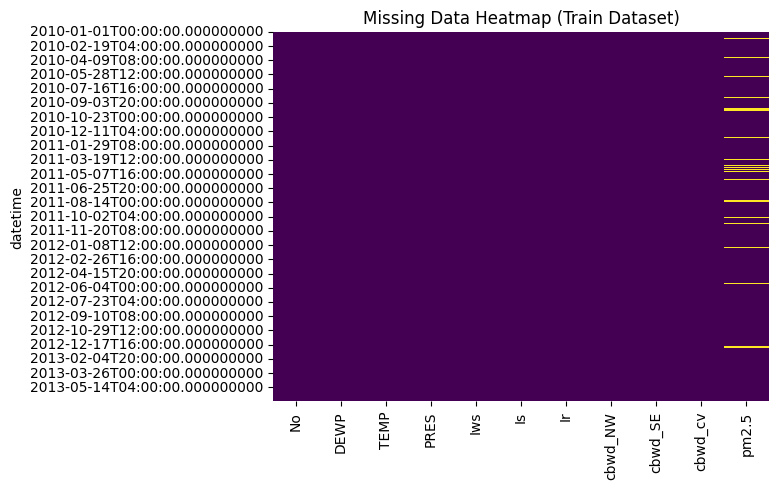

Missing values in train dataset:
No            0
DEWP          0
TEMP          0
PRES          0
Iws           0
Is            0
Ir            0
cbwd_NW       0
cbwd_SE       0
cbwd_cv       0
pm2.5      1921
dtype: int64


In [4]:
# Missing data visualization
sns.heatmap(train_data.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap (Train Dataset)')
plt.show()

# Print missing data counts
print("Missing values in train dataset:")
print(train_data.isnull().sum())


3. Handle Missing Data
Interpolation
Use interpolation to fill in missing values.

In [5]:
# Fill missing PM2.5 values using linear interpolation
train_data['pm2.5'] = train_data['pm2.5'].interpolate(method='linear')

# Verify no missing values remain
print("Missing values after interpolation:")
print(train_data.isnull().sum())


Missing values after interpolation:
No          0
DEWP        0
TEMP        0
PRES        0
Iws         0
Is          0
Ir          0
cbwd_NW     0
cbwd_SE     0
cbwd_cv     0
pm2.5      24
dtype: int64


In [31]:
# Drop rolling mean columns from the test dataset
test_data = test_data.drop(columns=['pm2.5_rolling_mean_3h', 'pm2.5_rolling_mean_24h'])


4. Feature Engineering
Moving Averages
Calculate rolling averages for PM2.5.

In [6]:
# Add rolling averages
train_data['pm2.5_rolling_mean_3h'] = train_data['pm2.5'].rolling(window=3).mean()
train_data['pm2.5_rolling_mean_24h'] = train_data['pm2.5'].rolling(window=24).mean()

# Ensure the test data has placeholders for rolling averages
test_data['pm2.5_rolling_mean_3h'] = np.nan
test_data['pm2.5_rolling_mean_24h'] = np.nan


Lagged Features
Add lagged PM2.5 values to capture recent trends.

In [7]:
# Add lagged features to train data
for lag in range(1, 4):  # Add 3 lag features
    train_data[f'pm2.5_lag_{lag}'] = train_data['pm2.5'].shift(lag)

# Drop NaN rows caused by lagging
train_data.dropna(inplace=True)


Derived Weather Features
Create new weather-related features.

In [8]:
# Add a humidity-temperature interaction term if columns exist
if 'TEMP' in train_data.columns and 'DEWP' in train_data.columns:
    train_data['temp_dewp_index'] = train_data['TEMP'] * train_data['DEWP']

# Apply the same for test data
if 'TEMP' in test_data.columns and 'DEWP' in test_data.columns:
    test_data['temp_dewp_index'] = test_data['TEMP'] * test_data['DEWP']


5. Normalize Data
Normalize the dataset to improve model convergence.

In [9]:
# Define the features to normalize
common_features = ['TEMP', 'DEWP', 'PRES', 'Iws',
                   'pm2.5_rolling_mean_3h', 'pm2.5_rolling_mean_24h',
                   'temp_dewp_index', 'cbwd_NW', 'cbwd_SE', 'cbwd_cv']

# Fit the scaler on common features from the train dataset
scaler = MinMaxScaler()
train_data[common_features] = scaler.fit_transform(train_data[common_features])

# Transform the common features in the test dataset using the same scaler
test_data[common_features] = scaler.transform(test_data[common_features])

# Separately normalize `pm2.5` and lagged features only in the training dataset
train_features_only_in_train = ['pm2.5', 'pm2.5_lag_1', 'pm2.5_lag_2', 'pm2.5_lag_3']
train_data[train_features_only_in_train] = scaler.fit_transform(train_data[train_features_only_in_train])


6. Split Data into Training, Validation, and Test Sets
Create datasets for training, validation, and testing.

In [10]:
from sklearn.model_selection import train_test_split

# Define input features (X) and target variable (y)
X = train_data.drop(columns=['pm2.5'])
y = train_data['pm2.5']

# Split into training (70%), validation (15%), and test (15%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Training set size:", X_train.shape)
print("Validation set size:", X_val.shape)
print("Test set size:", X_test.shape)


Training set size: (21440, 16)
Validation set size: (4594, 16)
Test set size: (4595, 16)


7. Visualize Feature Importance
Correlation between PM2.5 and features.

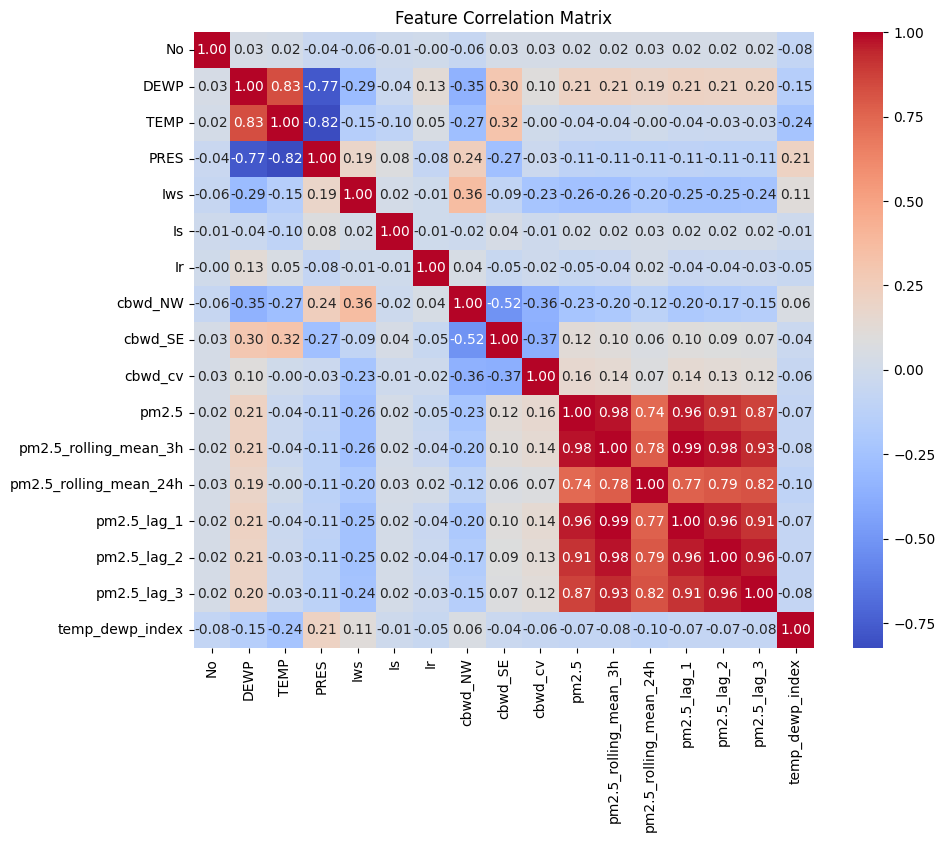

In [11]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(train_data.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()


Predictive Features Identified: Rolling averages and lagged features are highly correlated with pm2.5, confirming their importance for prediction.
Additional Insights: Weather features (e.g., temperature, dew point) show moderate correlations, which aligns with domain knowledge.
Potential for Feature Selection: Features with low correlations (e.g., wind speed) can be deprioritized to reduce noise in the model.

Section 2: Step 3

Section 3: Prepare Data for the Model

Reshape the data for the LSTM model:

In [12]:
# Reshape data for LSTM (samples, timesteps, features)
X_train_reshaped = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val_reshaped = X_val.values.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test_reshaped = X_test.values.reshape(X_test.shape[0], X_test.shape[1], 1)

Section 4: Define and Train the Model

Model architecture and training code

In [13]:
# Define the LSTM model
model = Sequential([
    LSTM(128, activation='tanh', return_sequences=True, input_shape=(X_train_reshaped.shape[1], 1)),
    Dropout(0.2),
    LSTM(64, activation='tanh', return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Train the model
history = model.fit(
    X_train_reshaped, y_train,
    validation_data=(X_val_reshaped, y_val),
    epochs=50,
    batch_size=32,
    verbose=2
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
670/670 - 9s - 13ms/step - loss: 0.0022 - mae: 0.0323 - val_loss: 0.0013 - val_mae: 0.0249
Epoch 2/50
670/670 - 3s - 5ms/step - loss: 0.0014 - mae: 0.0247 - val_loss: 0.0011 - val_mae: 0.0212
Epoch 3/50
670/670 - 6s - 8ms/step - loss: 0.0012 - mae: 0.0226 - val_loss: 0.0011 - val_mae: 0.0231
Epoch 4/50
670/670 - 5s - 7ms/step - loss: 0.0012 - mae: 0.0223 - val_loss: 0.0010 - val_mae: 0.0210
Epoch 5/50
670/670 - 3s - 5ms/step - loss: 0.0012 - mae: 0.0215 - val_loss: 0.0010 - val_mae: 0.0213
Epoch 6/50
670/670 - 3s - 5ms/step - loss: 0.0011 - mae: 0.0212 - val_loss: 9.4788e-04 - val_mae: 0.0195
Epoch 7/50
670/670 - 4s - 6ms/step - loss: 0.0011 - mae: 0.0207 - val_loss: 0.0011 - val_mae: 0.0212
Epoch 8/50
670/670 - 3s - 5ms/step - loss: 0.0010 - mae: 0.0199 - val_loss: 7.8425e-04 - val_mae: 0.0176
Epoch 9/50
670/670 - 3s - 5ms/step - loss: 8.8870e-04 - mae: 0.0187 - val_loss: 6.9097e-04 - val_mae: 0.0161
Epoch 10/50
670/670 - 4s - 6ms/step - loss: 8.2769e-04 - mae: 0.0179 - val

Section 5: Evaluate the Model

Visualize training and validation loss trends.

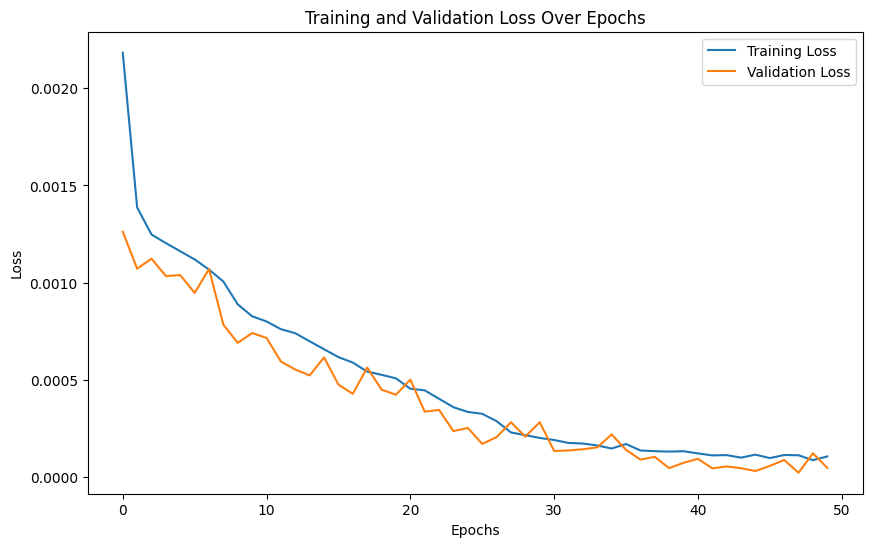

In [14]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Section 6: Save the Model and Predictions

Save the trained model and prepare predictions for Kaggle submission.

In [19]:
# Save the trained model
#model.save('best_lstm_model.h5')
model.save('best_lstm_model.keras')


# Define the number of timesteps (sliding window size)
n_timesteps = 16

# Create sequences for test data
test_sequences = []
test_indices = []

# Generate sliding windows
for i in range(len(test_data) - n_timesteps + 1):
    test_sequences.append(test_data.iloc[i:i+n_timesteps].values)
    test_indices.append(test_data.index[i + n_timesteps - 1])

# Convert to numpy array
X_test_reshaped = np.array(test_sequences)

print("New Test Data Shape (After Sliding Window):", X_test_reshaped.shape)

# Generate predictions
test_predictions = model.predict(X_test_reshaped)

# Ensure the predictions match the number of valid indices
assert len(test_predictions) == len(test_indices)

# Prepare the submission DataFrame
submission = pd.DataFrame({
    'datetime': test_indices,  # Use valid datetime indices
    'PM2.5': test_predictions.flatten()  # Flatten predictions to 1D
})

# Save the submission file
submission.to_csv('submission.csv', index=False)


New Test Data Shape (After Sliding Window): (13133, 16, 13)
411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Section 7: Model Diagram

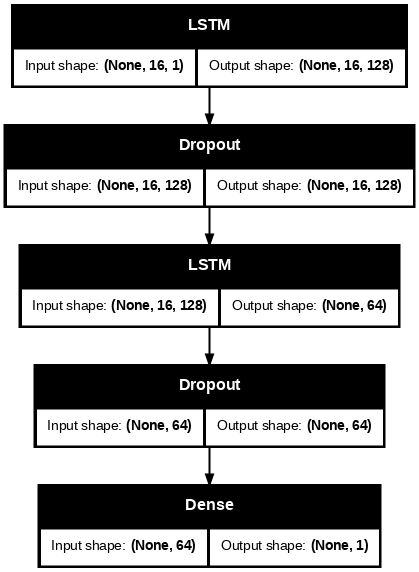

In [21]:
plot_model(model, to_file='model_architecture.png', show_shapes=True, dpi=72)

**None** represents a dynamic batch size, making the model flexible for training and inference.

In [22]:
# Download architecture diagram
from google.colab import files
files.download('model_architecture.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Step 4 Experiments

4.1 Experiments

In [25]:
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

# Function to train and evaluate LSTM model
def train_and_evaluate_lstm(units_1, units_2, dropout_rate, optimizer, learning_rate):
    model = Sequential([
        LSTM(units_1, activation='tanh', return_sequences=True, input_shape=(X_train_reshaped.shape[1], 1)),
        Dropout(dropout_rate),
        LSTM(units_2, activation='tanh', return_sequences=False),
        Dropout(dropout_rate),
        Dense(1)
    ])
    model.compile(optimizer=optimizer(learning_rate=learning_rate), loss='mse', metrics=['mae'])

    # Train the model
    history = model.fit(
        X_train_reshaped, y_train,
        validation_data=(X_val_reshaped, y_val),
        epochs=20,  # Reduced epochs for faster experimentation
        batch_size=32,
        verbose=0
    )

    # Predict on validation data and calculate RMSE
    val_predictions = model.predict(X_val_reshaped).flatten()
    rmse = np.sqrt(mean_squared_error(y_val, val_predictions))
    return rmse, model

# Experiment configurations 20 experiments total
experiments = [
    {'units_1': 128, 'units_2': 64, 'dropout_rate': 0.2, 'optimizer': Adam, 'learning_rate': 0.001},
    {'units_1': 128, 'units_2': 64, 'dropout_rate': 0.3, 'optimizer': Adam, 'learning_rate': 0.001},
    {'units_1': 256, 'units_2': 128, 'dropout_rate': 0.2, 'optimizer': Adam, 'learning_rate': 0.001},
    {'units_1': 64, 'units_2': 64, 'dropout_rate': 0.2, 'optimizer': RMSprop, 'learning_rate': 0.001},
    {'units_1': 64, 'units_2': 32, 'dropout_rate': 0.2, 'optimizer': SGD, 'learning_rate': 0.01},
    {'units_1': 128, 'units_2': 128, 'dropout_rate': 0.2, 'optimizer': Adam, 'learning_rate': 0.0005},
    {'units_1': 64, 'units_2': 128, 'dropout_rate': 0.3, 'optimizer': Adam, 'learning_rate': 0.001},
    {'units_1': 256, 'units_2': 256, 'dropout_rate': 0.2, 'optimizer': Adam, 'learning_rate': 0.0001},
    {'units_1': 32, 'units_2': 64, 'dropout_rate': 0.2, 'optimizer': RMSprop, 'learning_rate': 0.001},
    {'units_1': 128, 'units_2': 32, 'dropout_rate': 0.2, 'optimizer': RMSprop, 'learning_rate': 0.0005},
    {'units_1': 256, 'units_2': 128, 'dropout_rate': 0.4, 'optimizer': Adam, 'learning_rate': 0.001},
    {'units_1': 128, 'units_2': 64, 'dropout_rate': 0.2, 'optimizer': SGD, 'learning_rate': 0.01},
    {'units_1': 128, 'units_2': 128, 'dropout_rate': 0.2, 'optimizer': RMSprop, 'learning_rate': 0.005},
    {'units_1': 256, 'units_2': 64, 'dropout_rate': 0.3, 'optimizer': Adam, 'learning_rate': 0.0005},
    {'units_1': 64, 'units_2': 64, 'dropout_rate': 0.1, 'optimizer': Adam, 'learning_rate': 0.001},
    {'units_1': 128, 'units_2': 128, 'dropout_rate': 0.2, 'optimizer': Adam, 'learning_rate': 0.01},
    {'units_1': 256, 'units_2': 256, 'dropout_rate': 0.3, 'optimizer': RMSprop, 'learning_rate': 0.0005},
    {'units_1': 64, 'units_2': 32, 'dropout_rate': 0.2, 'optimizer': SGD, 'learning_rate': 0.005},
    {'units_1': 128, 'units_2': 64, 'dropout_rate': 0.1, 'optimizer': Adam, 'learning_rate': 0.0005},
    {'units_1': 64, 'units_2': 64, 'dropout_rate': 0.3, 'optimizer': Adam, 'learning_rate': 0.0001},
]

# Run experiments and collect results
results = []
models = []  # To store models
for i, config in enumerate(experiments):
    print(f"Running Experiment {i+1}...")
    rmse, model = train_and_evaluate_lstm(**config)
    results.append({
        'Experiment #': i+1,
        'Parameters': f"units_1={config['units_1']}, units_2={config['units_2']}, dropout_rate={config['dropout_rate']}, optimizer={config['optimizer'].__name__}, learning_rate={config['learning_rate']}",
        'RMSE': rmse
    })
    models.append(model)  # Store model for potential reuse

# Convert results to a DataFrame
results_df = pd.DataFrame(results)
print(results_df)

# Find the best model
best_model_index = results_df['RMSE'].idxmin()
best_model_config = experiments[best_model_index]
print(f"Best Model Config: {best_model_config}")
best_model = models[best_model_index]


Running Experiment 1...
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Running Experiment 2...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Running Experiment 3...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Running Experiment 4...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Running Experiment 5...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Running Experiment 6...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Running Experiment 7...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Running Experiment 8...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Running Experiment 9...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Running Experiment 10...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Running Experiment 11...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Running Experiment 12...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Running Experiment 13...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Running Experiment 14...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Running Experiment 15...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Running Experiment 16...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Running Experiment 17...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Running Experiment 18...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Running Experiment 19...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Running Experiment 20...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
    Experiment #                                         Parameters      RMSE
0              1  units_1=128, units_2=64, dropout_rate=0.2, opt...  0.022284
1              2  units_1=128, units_2=64, dropout_rate=0.3, opt...  0.022558
2              3  units_1=256, units_2=128, dropout_rate=0.2, op...  0.018206
3              4  units_1=64, units_2=64, dropout_rate=0.2, opti...  0.032746
4              5  units_1=64, units_2=32, dropout_rate=0.2, opti...  0.046380
5              6  units_1=128, units_2=128, dropout_rate=0.2, op...  0.025835
6              7  units_1=64, units_2=128, dropout_rate=0.3, opt...  0.020928
7              8  units_1=256, units_2=256, dropout_rate=0.2, op...  0.031978
8              9  units_1=32, units_2=64, dropout_rate=0.2, opti...  0.036464
9             10  units_1=128, units_2=32, dropout_rate=0.2, opt...  0.033178
10            11  units_1=256, units_2=128, dropout_rate=0.4, op...  0.013399
11            12  units

Step 4.2 Final Model Train

In [26]:
# Combine training and validation datasets
X_train_final = np.vstack([X_train_reshaped, X_val_reshaped])
y_train_final = np.concatenate([y_train, y_val])

# Retrain the best model on the full dataset
final_model = Sequential([
    LSTM(best_model_config['units_1'], activation='tanh', return_sequences=True, input_shape=(X_train_final.shape[1], 1)),
    Dropout(best_model_config['dropout_rate']),
    LSTM(best_model_config['units_2'], activation='tanh', return_sequences=False),
    Dropout(best_model_config['dropout_rate']),
    Dense(1)
])

final_model.compile(optimizer=best_model_config['optimizer'](learning_rate=best_model_config['learning_rate']), loss='mse', metrics=['mae'])
final_model.fit(X_train_final, y_train_final, epochs=50, batch_size=32, verbose=2)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
814/814 - 9s - 11ms/step - loss: 0.0158 - mae: 0.0333
Epoch 2/50
814/814 - 5s - 6ms/step - loss: 0.0012 - mae: 0.0231
Epoch 3/50
814/814 - 5s - 6ms/step - loss: 0.0011 - mae: 0.0213
Epoch 4/50
814/814 - 5s - 6ms/step - loss: 9.4710e-04 - mae: 0.0199
Epoch 5/50
814/814 - 4s - 5ms/step - loss: 8.9415e-04 - mae: 0.0193
Epoch 6/50
814/814 - 4s - 5ms/step - loss: 7.3586e-04 - mae: 0.0176
Epoch 7/50
814/814 - 6s - 8ms/step - loss: 6.6039e-04 - mae: 0.0166
Epoch 8/50
814/814 - 9s - 11ms/step - loss: 6.4437e-04 - mae: 0.0163
Epoch 9/50
814/814 - 5s - 7ms/step - loss: 6.2848e-04 - mae: 0.0163
Epoch 10/50
814/814 - 5s - 6ms/step - loss: 6.0966e-04 - mae: 0.0159
Epoch 11/50
814/814 - 6s - 8ms/step - loss: 6.2675e-04 - mae: 0.0164
Epoch 12/50
814/814 - 4s - 5ms/step - loss: 7.2903e-04 - mae: 0.0173
Epoch 13/50
814/814 - 5s - 6ms/step - loss: 8.4193e-04 - mae: 0.0184
Epoch 14/50
814/814 - 5s - 7ms/step - loss: 5.8984e-04 - mae: 0.0158
Epoch 15/50
814/814 - 4s - 5ms/step - loss: 4.1897e-0

Step 4.3

In [27]:
# Predict on the test dataset
test_predictions = final_model.predict(X_test_reshaped).flatten()

# Prepare the submission DataFrame
submission = pd.DataFrame({
    'datetime': test_indices,  # From sliding window logic
    'PM2.5': test_predictions
})

# Save submission file
submission.to_csv('submission.csv', index=False)

# Download the file in Colab
from google.colab import files
files.download('submission.csv')


411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [29]:
# Check the shape of the test input
print("Shape of X_test_reshaped:", X_test_reshaped.shape)

# Check for NaN or invalid values in the test input
assert not pd.isnull(X_test_reshaped).any(), "Test input contains NaN values!"
print("Sample of test input:", X_test_reshaped[:1])


Shape of X_test_reshaped: (13133, 16, 13)


AssertionError: Test input contains NaN values!

In [32]:
# Check for missing values in the original test data
print("Missing values in test_data:")
print(test_data.isnull().sum())

# Optionally, inspect a few rows with missing values
print(test_data[test_data.isnull().any(axis=1)])


Missing values in test_data:
No                 0
DEWP               0
TEMP               0
PRES               0
Iws                0
Is                 0
Ir                 0
cbwd_NW            0
cbwd_SE            0
cbwd_cv            0
temp_dewp_index    0
dtype: int64
Empty DataFrame
Columns: [No, DEWP, TEMP, PRES, Iws, Is, Ir, cbwd_NW, cbwd_SE, cbwd_cv, temp_dewp_index]
Index: []
